# Compression examples
In this notebook we compare constraints on cosmological parameters obtained with different types of compressions (shapefit, direct).
Notebooks fs_shapefit_examples.ipynb & fs_direct_examples.ipnyb must be run first to produce the samples needed in this notebook.

## BAO compression
As a warm-up, what constraints on $\Omega_m$ do we obtain from an isotropic BAO fit?

In [1]:
from desilike.samples import Chain
from desilike import setup_logging

setup_logging()
chain = Chain.load('_tests/chain_bao_0.npy').remove_burnin(0.3)
z = 1.

[000000.00] [0/1] 02-05 15:02  Chain                     INFO     Loading _tests/chain_bao_0.npy.


In [2]:
import numpy as np

from desilike.theories.primordial_cosmology import Cosmoprimo
from desilike.observables.galaxy_clustering import BAOCompressionObservable
from desilike.likelihoods import ObservablesGaussianLikelihood

quantities = ['qiso']
observable = BAOCompressionObservable(data=chain, covariance=chain, z=z, quantities=quantities, fiducial='DESI')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

# Note that you can directly pass arrays as data and covariance, in addition to "quantities"
data = chain.choice(params=quantities, return_type='nparray')
covariance = chain.cov(params=quantities, return_type='nparray')
observable = BAOCompressionObservable(data=data, covariance=covariance, quantities=quantities, z=z)
likelihood2 = ObservablesGaussianLikelihood(observables=[observable])
assert np.allclose(likelihood2(Omega_m=0.29), likelihood(Omega_m=0.29))

[000000.18] [0/1] 02-05 15:02  BAOCompressionObservable  INFO     Found BAO quantities ['qiso'].
[000000.32] [0/1] 02-05 15:02  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.32] [0/1] 02-05 15:02  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.32] [0/1] 02-05 15:02  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.33] [0/1] 02-05 15:02  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.33] [0/1] 02-05 15:02  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[000000.55] [0/1] 02-05 15:02  BAOCompressionObservable  INFO     Found BAO quantit

In [3]:
# A bit of emulation, to speed up inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=3))
emulator.set_samples()
emulator.fit()
likelihood.init.update(observables=[emulator.to_calculator()])

[000000.94] [0/1] 02-05 15:02  Emulator                  INFO     Varied parameters: ['Omega_m'].
[000000.94] [0/1] 02-05 15:02  Emulator                  INFO     Found varying ['flattheory'] and fixed ['flatdata', 'covariance', 'bao_quantities'] outputs.
[000000.94] [0/1] 02-05 15:02  Differentiation           INFO     Varied parameters: ['Omega_m'].
[000001.28] [0/1] 02-05 15:02  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000001.28] [0/1] 02-05 15:02  Differentiation           INFO     Omega_m grid is [0.31119172 0.31319172 0.31519172 0.31719172 0.31919172].


In [4]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.01})

[000001.53] [0/1] 02-05 15:02  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[000004.73] [0/1] 02-05 15:02  EmceeSampler              INFO     Diagnostics:
[000004.73] [0/1] 02-05 15:02  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.194; not < 0.01.
[000004.73] [0/1] 02-05 15:02  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.194.
[000004.74] [0/1] 02-05 15:02  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.465.
[000004.74] [0/1] 02-05 15:02  EmceeSampler              INFO     - max Geweke is 0.557.
[000004.74] [0/1] 02-05 15:02  EmceeSampler              INFO     - Geweke p-value is nan.
[000004.74] [0/1] 02-05 15:02  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 18.8.
[000007.62] [0/1] 02-05 15:02  EmceeSampler              INFO     Diagnostics:
[000007.62] [0/1] 02-05 15:02  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is

[000031.00] [0/1] 02-05 15:03  EmceeSampler              INFO     - Geweke p-value is nan.
[000031.00] [0/1] 02-05 15:03  EmceeSampler              INFO     - (1500 iterations / integrated autocorrelation time) (reliable) is 75.
[000031.00] [0/1] 02-05 15:03  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0621.
[000033.95] [0/1] 02-05 15:03  EmceeSampler              INFO     Diagnostics:
[000033.95] [0/1] 02-05 15:03  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.00531; < 0.01.
[000033.95] [0/1] 02-05 15:03  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.00531.
[000033.96] [0/1] 02-05 15:03  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0492.
[000033.96] [0/1] 02-05 15:03  EmceeSampler              INFO     - max Geweke is 0.275.
[000033.96] [0/1] 02-05 15:03  EmceeSampler              INFO     - Geweke p-value is nan.
[000033.97] [0/1] 02-05 15:03  EmceeSampler 

[Chain(shape=(3600, 4), params=ParameterCollection(['Omega_m', 'logposterior', 'loglikelihood', 'logprior']))]

[000037.39] [0/1] 02-05 15:03  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


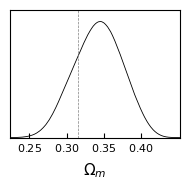

In [5]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.bao.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})

## ShapeFit compression
Now turn to shapefit compression.

In [6]:
from desilike.observables.galaxy_clustering import ShapeFitCompressionObservable

chain = Chain.load('_tests/chain_fs_shapefit_0.npy').remove_burnin(0.3)

quantities = ['qpar', 'qper', 'df', 'dm']
observable = ShapeFitCompressionObservable(data=chain, covariance=chain, z=z, quantities=quantities)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

# A bit of emulation, to speed up inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=3))
emulator.set_samples()
emulator.fit()
likelihood.init.update(observables=[emulator.to_calculator()])

[000037.73] [0/1] 02-05 15:03  Chain                     INFO     Loading _tests/chain_fs_shapefit_0.npy.
[000037.74] [0/1] 02-05 15:03  ShapeFitCompressionObservable INFO     Found BAO quantities ['qpar', 'qper'].
[000037.74] [0/1] 02-05 15:03  ShapeFitCompressionObservable INFO     Found FS quantities ['df', 'dm'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000041.95] [0/1] 02-05 15:03  Emulator                  INFO     Varied parameters: ['h', 'Omega_m', 'logA'].
[000041.96] [0/1] 02-05 15:03  Emulator                  INFO     Found varying ['flattheory'] and fixed ['flatdata', 'covariance', 'bao_quantities', 'fs_quantities'] outputs.
[000041.96] [0/1] 02-05 15:03  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'logA'].
[000046.71] [0/1] 02-05 15:03  Differentiation           INFO     Using finite-differentiation for parameter h.
[000047.69] [0/1] 02-05 15:03  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000048.62] [0/1] 02-05 15:03  Differentiation           INFO     Using finite-differentiation for parameter logA.
[000048.62] [0/1] 02-05 15:03  Differentiation           INFO     h grid is [0.6696 0.6716 0.6736 0.6756 0.6776].
[000048.62] [0/1] 02-05 15:03  Differentiation           INFO     Omega_m grid is [0.31319172 0.31419172 0.31519172 0.31619172 0.31719172].
[00

In [7]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.05})

[000079.14] [0/1] 02-05 15:03  ZeusSampler               INFO     Varied parameters: ['h', 'Omega_m', 'logA'].
[000079.52] [0/1] 02-05 15:03  root                      INFO     Initialising ensemble of 8 walkers...
[000134.78] [0/1] 02-05 15:04  ZeusSampler               INFO     Diagnostics:
[000134.79] [0/1] 02-05 15:04  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0638; not < 0.05.
[000134.79] [0/1] 02-05 15:04  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0178.
[000134.80] [0/1] 02-05 15:04  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.118.
[000134.80] [0/1] 02-05 15:04  ZeusSampler               INFO     - max Geweke is 0.452.
[000134.80] [0/1] 02-05 15:04  ZeusSampler               INFO     - Geweke p-value is 0.244.
[000134.81] [0/1] 02-05 15:04  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 35.5.
[000134.84] [0/1] 02-05 15:04  root                    

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000192.36] [0/1] 02-05 15:05  ZeusSampler               INFO     Diagnostics:
[000192.36] [0/1] 02-05 15:05  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0109; < 0.05.
[000192.37] [0/1] 02-05 15:05  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is -0.000165.
[000192.38] [0/1] 02-05 15:05  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0498.
[000192.38] [0/1] 02-05 15:05  ZeusSampler               INFO     - max Geweke is 0.467.
[000192.38] [0/1] 02-05 15:05  ZeusSampler               INFO     - Geweke p-value is 0.0873.
[000192.39] [0/1] 02-05 15:05  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) (reliable) is 79.5.
[000192.39] [0/1] 02-05 15:05  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.164.
[000192.42] [0/1] 02-05 15:05  root                      INFO     Initialising ensemble of 8 walkers...
[000248.03] [0/1] 02-05 15:

[Chain(shape=(2100, 8), params=ParameterCollection(['h', 'Omega_m', 'logA', 'logposterior', 'loglikelihood', 'logprior']))]

[000474.81] [0/1] 02-05 15:10  Chain                     INFO     Loading _tests/chain_fs_direct_0.npy.
Removed no burn in
Removed no burn in


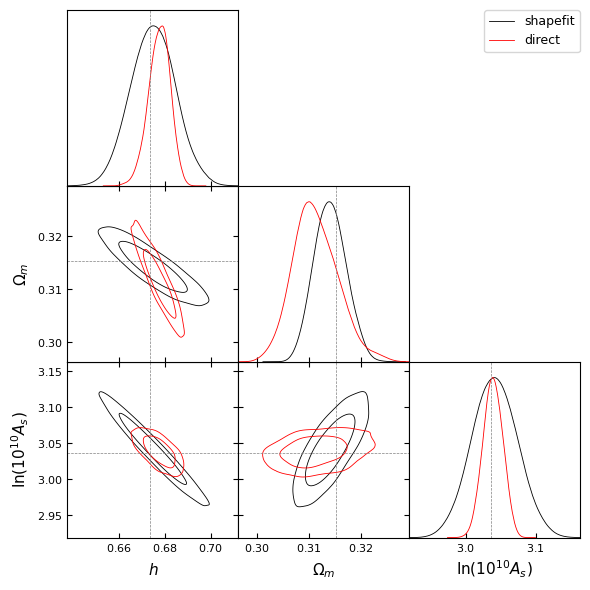

In [8]:
from desilike.samples import plotting
chain_shapefit = sampler.chains[0].remove_burnin(0.1)
chain_direct = Chain.load('_tests/chain_fs_direct_0.npy').remove_burnin(0.5)
plotting.plot_triangle([chain_shapefit, chain_direct], fill=True, labels=['shapefit', 'direct'], markers={'Omega_m': fiducial.Omega0_m, 'h': fiducial.h, 'logA': np.log(10**10 * fiducial.A_s), 'n_s': fiducial.n_s})